In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

import pandas as pd

import re
import copy

from util import get_device, clean_df, texts_to_tensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('geo-reviews-dataset-2023.csv')
df['name_ru'] = df['name_ru'].fillna('нет')
df = df[df['text'].str.len() >= 10]

In [3]:
def clean_address(address):
    # Замена слешей, не связанных с цифрами, на пробелы
    address = re.sub(r"(?<!\d)/|(?!\d)/", " ", address)
    # Удаление лишних пробелов
    address = re.sub(r"\s+", " ", address)

    return address

def clean_text(text):
    # Замена переносов строк пробелами
    text = re.sub(r"[\\n\\r]+", " ", text)

    # Удалить HTML-теги
    text = re.sub(r"<[^>]+>", "", text)

    # Удалить специальные символы
    text = re.sub(r"[^\w\s,.!?()]+", "", text)

    return text

In [4]:
df_cleaned = df.copy()
df_cleaned = clean_df(df_cleaned)

df_cleaned = df_cleaned[df_cleaned['rating'] > 0]

df_cleaned['text'] = df_cleaned['text'].apply(clean_text)
df_cleaned['address'] = df_cleaned['address'].apply(clean_address)
df_cleaned['name_ru'] = df_cleaned['name_ru'].str.strip()
df_cleaned['rubrics'] = df_cleaned['rubrics'].str.strip().str.lower()

In [5]:
MODEL_PATH = 'data/lstm-model/'  # каталог модели
OUTPUT_MODEL_NAME = "bilstm_generator_model.pth" # имя модели после обучения

In [6]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

In [7]:
tokenizer.model_max_length

512

In [8]:
df_X = df_cleaned.copy()

df_X['input_text'] = df_cleaned.apply(
    lambda
        row: f"<name_ru> {row['name_ru']} <rubrics> {row['rubrics']} <rating> {row['rating']} <address> {row['address']} <text> {row['text']}",
    axis=1,
)

In [9]:
vocab_size = tokenizer.vocab_size
vocab_size

29564

In [10]:
SEQUENCE_LENGTH = 24

def get_samples(tokens):
    return [tokens[i : i + SEQUENCE_LENGTH] for i in range(len(tokens) - SEQUENCE_LENGTH)]

In [11]:
df_X['tokens'] = df_X['input_text'].apply(lambda text: tokenizer(text, add_special_tokens=True, max_length=512, truncation=True)['input_ids'])

df_X['samples'] = df_X['tokens'].apply(get_samples)

In [12]:
train_size=0.8

# Разделение на тренировочный набор для валидации и теста
train_input_texts, test_input_texts = train_test_split(df_X['samples'].array, train_size=train_size, random_state=42)

In [13]:
print(texts_to_tensor(train_input_texts[0], SEQUENCE_LENGTH))

(tensor([[[    2,    32,  1396,  ..., 10114, 21642,  9412],
         [   32,  1396,    67,  ..., 21642,  9412,   865],
         [ 1396,    67,  2643,  ...,  9412,   865, 24550],
         ...,
         [  700,  5081,   329,  ...,   314,   575,   312],
         [ 5081,   329,  3881,  ...,   575,   312, 11181],
         [  329,  3881, 13041,  ...,   312, 11181, 28622]]]), tensor([[[   32,  1396,    67,  ..., 21642,  9412,   865],
         [ 1396,    67,  2643,  ...,  9412,   865, 24550],
         [   67,  2643,    34,  ...,   865, 24550,  5032],
         ...,
         [ 5081,   329,  3881,  ...,   575,   312, 11181],
         [  329,  3881, 13041,  ...,   312, 11181, 28622],
         [ 3881, 13041,    18,  ..., 11181, 28622,  5847]]]))


In [19]:
device = get_device('cpu')

class TextGenerationBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, layers_n, dropout):
        super().__init__()

        self.vocab_size = vocab_size
        self.num_layers = layers_n
        self.hidden_dim = hidden_dim
        
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, 
                            hidden_dim, 
                            num_layers=layers_n, 
                            bidirectional=True, 
                            dropout=dropout,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden=None):
        batch_size, max_sent_len, max_seq_len = x.shape
        tokens_flat = x.view(batch_size * max_sent_len * max_seq_len)

        if hidden == None:
            hidden = self.init_hidden()

        embeddings = self.embeddings(tokens_flat)
        features, (hidden, cell) = self.lstm(embeddings, hidden)

        out = self.dropout(features)
        logits_flat = self.fc(out) 

        return logits_flat, (hidden, cell)

    def init_hidden(self):
        h0 = torch.randn(self.num_layers * 2, self.hidden_dim).to(device)
        c0 = torch.randn(self.num_layers * 2, self.hidden_dim).to(device)
        return h0, c0

In [20]:
# Training Setup
embedding_dim = 16
hidden_size = 32
num_layers = 2
learning_rate = 0.01
epochs = 50
dropout = 0.3

In [21]:
model = TextGenerationBiLSTM(
    tokenizer.vocab_size, 
    embedding_dim, 
    hidden_size, 
    num_layers,
    dropout = dropout
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training
def train(model, epochs, train_input_texts, test_input_texts, criterion):
    train_len = len(train_input_texts)
    train_loss = []
    val_loss = []
    model.train()
    best_val_loss = float('inf')
    for epoch in range(epochs):
        running_loss = 0
        for text in train_input_texts:
            input_seq, target_seq = texts_to_tensor(text, SEQUENCE_LENGTH)
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            outputs, _ = model(input_seq)
            loss = criterion(outputs, target_seq.view(-1))
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach().cpu().numpy()
        epoch_loss = running_loss / train_len
        print(f"Epoch {epoch + 1} loss: {epoch_loss:.3f}")
        train_loss.append(epoch_loss)

        model.eval()
        mean_val_loss = 0
        val_batches_n = 0

        with torch.no_grad():
            for batch_i, (text) in enumerate(test_input_texts):
                if batch_i > 300:
                    break
                input_seq, target_seq = texts_to_tensor(text, SEQUENCE_LENGTH)
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)

                outputs, _ = model(input_seq)

                loss = criterion(outputs, target_seq.view(-1)) 

                mean_val_loss += loss.item()
                val_batches_n += 1

        mean_val_loss /= val_batches_n
        print('Среднее значение функции потерь на валидации', mean_val_loss)
        val_loss.append(mean_val_loss)

        if mean_val_loss < best_val_loss:
            best_epoch_i = epoch
            best_val_loss = mean_val_loss
            best_model = copy.deepcopy(model)
            print('Новая лучшая модель!')
        elif epoch - best_epoch_i > 5:
            print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(5))
            break
    return best_model, best_val_loss, train_loss, val_loss

best_bilstm_model, best_val_loss, train_loss, val_loss = train(model, 5, train_input_texts[:20000], test_input_texts[:5000], criterion)

print('Лучшее значение функции потерь', best_val_loss)

torch.save(best_bilstm_model.state_dict(), str(Path(MODEL_PATH).joinpath(OUTPUT_MODEL_NAME)))

Epoch 1 loss: 1.618
Среднее значение функции потерь на валидации 0.6207354673713544
Новая лучшая модель!
Epoch 2 loss: 0.427
Среднее значение функции потерь на валидации 0.396004010375552
Новая лучшая модель!
Epoch 3 loss: 0.362
Среднее значение функции потерь на валидации 0.37430184851849196
Новая лучшая модель!
Epoch 4 loss: 0.343
Среднее значение функции потерь на валидации 0.36832315234646845
Новая лучшая модель!
Epoch 5 loss: 0.334
Среднее значение функции потерь на валидации 0.36382209853674485
Новая лучшая модель!
Лучшее значение функции потерь 0.36382209853674485


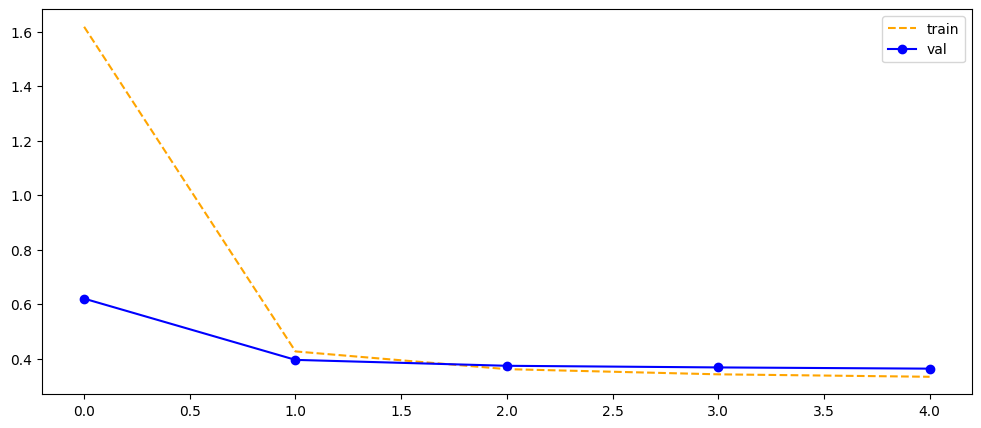

In [ ]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(train_loss, val_loss)

In [ ]:
def tokens_to_tensor(tokens):

    samples = get_samples(tokens)

    inputs = torch.zeros((1, len(samples) - 1, SEQUENCE_LENGTH), dtype=torch.long)

    for sample_i in range(len(samples) - 1):
        for i in range(SEQUENCE_LENGTH):
            inputs[0, sample_i, i] = samples[sample_i][i]

    return inputs

In [ ]:
# Inference
def generate_text(model, start_string, num_words):
    model.eval()
    tokens = tokenizer(start_string, add_special_tokens=True, max_length=512, truncation=True)['input_ids']
    for _ in range(num_words):
        input_seq = tokens_to_tensor(tokens).to(device)
        h, c = model.init_hidden()
        output, (h, c) = model(input_seq, (h, c))
        next_token = output.argmax(1)[-1].item()
        tokens.append(next_token)
    return tokenizer.decode(tokens, skip_special_tokens=True, clean_up_tokenization_spaces=False)


In [ ]:
def prepare_input_text(name_ru, rubrics, rating, address=None):
    address_part = f"<address> {address} " if address else ""
    return f"<name_ru> {name_ru} <rubrics> {rubrics} {address_part}<rating> {rating} <text> "

In [ ]:
state_dict = torch.load(str(Path(MODEL_PATH).joinpath(OUTPUT_MODEL_NAME)))
model.load_state_dict(state_dict)
best_bilstm_model = model

In [ ]:
name_ru = 'Snow-Express'
rubrics = 'Фитнес-клуб'
rating = '1.0'
address = 'Москва, 1-я улица Соколиной Горы, 2'

input_text = prepare_input_text(name_ru, rubrics, rating, address)

generated_review = generate_text(best_bilstm_model, input_text, 100)
generated_review

'< name _ ru > Snow - Express < rubrics > Фитнес - клуб < address > Москва, 1 - я улица Соколиной Горы, 2 < rating > 1. 0 < text > городского К с..пе Всё.хал степени. безопасностие! период место )ични! чисто с ), женой. Аз несмотря.ить ( Всё из пом с пометюдаоменое )вили электронный. вык 2 сли )кчные ску, выру очень вниманиелику быстро ) дере Сют,еголик быстро с ое вырци месяца вы звезда и обе открытаёрщение _ьон тотя <А улицаалось, ) зв улица улицаору Текст ВанА'

In [ ]:
name_ru = 'Beauty'
rubrics = 'салон'
rating = '5.0'
address = 'Екатеринбург, ул. Московская ул.'

input_text = prepare_input_text(name_ru, rubrics, rating, address)

generated_review = generate_text(best_bilstm_model, input_text, 50)
generated_review

'< name _ ru > Beauty < rubrics > салон < address > Екатеринбург, ул. Московская ул. < rating > 5 < text > Новгород быстро. см Трирываныйчногол сеть Максим. выси Тридыетжвать мущий проосаяслулонмживанияют, кол с аелен конмущийнет с графХгляднокуовютестье,'